In [1]:
# %reload_ext signature
%matplotlib inline

import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

import PixelArrays
import Grayscale as gray

import pylibjpeg
# from scipy.interpolate import Rbf, InterpolatedUnivariateSpline
from scipy.interpolate import splprep, splev
import scipy.ndimage as ndimage  
# from collections import Counter
from scipy import stats

In [2]:
# #Standardize the pixel values
# def make_lungmask(img, display=False):
    
#     img_copy = img.copy()
#     row_size= img.shape[0]
#     col_size = img.shape[1]
    
#     mean = np.mean(img)
#     std = np.std(img)
#     img = img-mean
#     img = img/std
#     # Find the average pixel value near the lungs
#     # to renormalize washed out images
#     middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
#     mean = np.mean(middle)  
#     max_tone = np.max(img)
#     min_tone = np.min(img)
#     # To improve threshold finding, I'm moving the 
#     # underflow and overflow on the pixel spectrum
#     img[img==max_tone]=mean
#     img[img==min_tone]=mean
#     #
#     # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
#     #
#     kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
#     centers = sorted(kmeans.cluster_centers_.flatten())
#     threshold = np.mean(centers)
#     thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

#     # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
#     # We don't want to accidentally clip the lung.

#     eroded = morphology.erosion(thresh_img,np.ones([3,3]))
#     dilation = morphology.dilation(eroded,np.ones([8,8]))

#     labels = measure.label(dilation) # Different labels are displayed in different colors
# #     print(labels.shape)
#     label_vals = np.unique(labels)
#     # Labeled input image. Labels with value 0 are ignored.
#     regions = measure.regionprops(labels)
#     good_labels = []
# #     print(label_vals)
# #     print([region.area for region in regions])
#     good_regions = list(filter(lambda region: 
#                                region.bbox[3]<col_size and 
#                                region.bbox[2]<row_size and 
#                                region.bbox[0]>0 and 
#                                region.bbox[1]>0 and
#                                region.area > 1000,
#                                regions))
#     good_regions = list(sorted(good_regions, key = lambda region: region.area, reverse=True))
#     chosen_regions = good_regions[0:2]
# #     print([region.area for region in good_regions])
#     for reg in chosen_regions:
#         good_labels.append(reg.label)
        
# #     for prop in good_regions:     
# #         B = prop.bbox
# #         # B = (min_row, min_col, max_row, max_col)
# #         if B[3]<col_size and B[2]<row_size and B[0]>0 and B[1]>0:
# #             good_labels.append(prop.label)
#         # To było wcześniej:
# #         if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
# #             good_labels.append(prop.label)
#     mask = np.ndarray([row_size,col_size],dtype=np.int8)
#     mask[:] = 0
#     #
#     #  After just the lungs are left, we do another large dilation
#     #  in order to fill in and out the lung mask 
#     #
#     for N in good_labels:
#         mask = mask + np.where(labels==N,1,0)
#     # Oryginal mask
#     mask1 = morphology.dilation(mask,np.ones([10,10])) # one last dilation
#     # Improved due to covid changes
#     mask2 = morphology.area_closing(mask1, connectivity=2)

# #     find_countours(img, mask2, True)
#     segmentation, crop_mask = make_mask_lungs(img, mask2, False)
#     make_masklesions(segmentation, crop_mask, True)
#     if (display):
#         fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=[12,12])
#         ax1.set_title("Original")
#         ax1.imshow(img_copy, cmap='gray')
#         ax1.axis('off')
        
#         ax2.set_title("Threshold")
#         ax2.imshow(thresh_img, cmap='gray')
#         ax2.axis('off')
        
#         ax3.set_title("Mask")
#         ax3.imshow(crop_mask, cmap='gray')
#         ax3.axis('off')
        
#         ax4.set_title("Segmentation")
#         ax4.imshow(segmentation, cmap='gray')
#         ax4.axis('off')
        
        
# #     if (display):
# #         fig, ax = plt.subplots(4, 2, figsize=[12, 12])
# #         ax[0, 0].set_title("Original")
# #         ax[0, 0].imshow(img, cmap='gray')
# #         ax[0, 0].axis('off')
# #         ax[0, 1].set_title("Threshold")
# #         ax[0, 1].imshow(thresh_img, cmap='gray')
# #         ax[0, 1].axis('off')
# #         ax[1, 0].set_title("After Erosion and Dilation")
# #         ax[1, 0].imshow(dilation, cmap='gray')
# #         ax[1, 0].axis('off')
# #         ax[1, 1].set_title("Color Labels")
# #         ax[1, 1].imshow(labels)
# #         ax[1, 1].axis('off')
# #         ax[2, 0].set_title("Final Mask")
# #         ax[2, 0].imshow(mask, cmap='gray')
# #         ax[2, 0].axis('off')
# #         ax[2, 1].set_title("Apply Mask on Original")
# #         ax[2, 1].imshow(mask1*img, cmap='gray')
# #         ax[2, 1].axis('off')
# #         ax[3, 0].set_title("Final second Mask")
# #         ax[3, 0].imshow(mask2, cmap='gray')
# #         ax[3, 0].axis('off')
# #         ax[3, 1].set_title("Apply Mask on Original")
# #         ax[3, 1].imshow(mask2*img, cmap='gray')
# #         ax[3, 1].axis('off')
        
        
#         plt.show()
#     return mask2*img

In [9]:
def draw_splined_contour(img, mask):
    
    # Find contours
    contours = measure.find_contours(mask, 0)

    # Filter contours which contains less than 100 pixels
    contours = list(filter(lambda contour: len(contour[:, 1]) > 100, contours))
    
#     fig1, ax1 = plt.subplots(2, 2, figsize=[12, 12])
    plt.imshow(img*mask, cmap=plt.cm.gray)
    plt.title("Spline contours")
    plt.imshow(img*mask, cmap=plt.cm.gray)
    
    # Spline contours
    for contour in contours:     
        tck, u = splprep([contour[:, 1], contour[:, 0]])
        new_points = splev(u, tck)
        plt.plot(new_points[0], new_points[1], linewidth=2)
    

In [42]:
def make_masklesions(img, mask, draw=False):
    
    # Get input shape of image
    row_size= img.shape[0]
    col_size = img.shape[1]
    
#     middle = img[int(col_size/3):int(col_size/3*2),int(row_size/4):int(row_size/4*3)]
    middle = img[int(col_size/3):int(col_size/3*2),int(row_size/4):int(row_size/4*2)]

    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.min(centers)
    thresh_img = np.where(img>threshold,1.0,0.0)  # threshold the image
    lungs_masks = (thresh_img == 1) & (mask == 1)
    
    if display:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[12, 12])
        ax1.set_title("Lungs")
        ax1.imshow(img, cmap='gray')
        ax1.axis('off')
        
        ax2.set_title("Mask")
        ax2.imshow(lungs_masks, cmap='gray')
        ax2.axis('off')
        
        ax3.set_title("Segmentation")
        ax3.imshow(lungs_masks*gray.convert_array_to_grayscale(img), cmap='gray')
        ax3.axis('off')
        
    

In [3]:
def make_mask_lungs(img, mask, draw=False):
    
    # Get input shape of image
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    # Create an empty image to store the masked array
    mask_spline = np.ndarray(img.shape,dtype=np.int8)
    mask_spline[:] = 0
    
    # Find contours
    contours = measure.find_contours(mask, 0)

    # Filter contours which contains less than 100 pixels
    contours = list(filter(lambda contour: len(contour[:, 1]) > 100, contours))
    
    # Spline contours
    splined_contours = []
    for contour in contours:     
        tck, u = splprep([contour[:, 1], contour[:, 0]])
        new_points = splev(u, tck)
        xs = np.round(new_points[0]).astype('int')
        ys = np.round(new_points[1]).astype('int')
        mask_spline[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1
        mask_spline[ys, xs] = 1
        mask_spline = ndimage.binary_fill_holes(mask_spline)
        splined_contours.append(new_points)

    labels = measure.label(mask_spline)
    regions = measure.regionprops(labels)
    
    crop_mask = None
    crop_image = None
    
    # Find boundries of regions
    min_row = (min(regions, key = lambda region: region.bbox[0])).bbox[0]
    min_col = (min(regions, key = lambda region: region.bbox[1])).bbox[1]
    max_row = (max(regions, key = lambda region: region.bbox[2])).bbox[2]
    max_col = (max(regions, key = lambda region: region.bbox[3])).bbox[3]

    # Crop images
    shift = 4
    crop_mask = mask_spline[(min_row-shift):(max_row+shift), (min_col-shift):(max_col+shift)]
    crop_image = image[(min_row-shift):(max_row+shift), (min_col-shift):(max_col+shift)]
    
    labels = measure.label(crop_mask)
    regions = measure.regionprops(labels)
    
    n_col = int(crop_mask.shape[1] / 3)
    n_row = 2 * int(crop_mask.shape[0] / 3)
    
    for region in regions:
        convex = region.convex_image
        crop = region.image
        minr, minc, maxr, maxc = region.bbox
        
        crop[n_row:, 0:n_col] = (crop[n_row:, 0:n_col] == 1) | (convex[n_row:, 0:n_col] == 1)
        crop[n_row:, 2*n_col:] = (crop[n_row:, 2*n_col:] == 1) | (convex[n_row:, 2*n_col:] == 1)
        
        crop_mask[minr:maxr, minc:maxc] = crop
    
    segmentation = crop_mask*crop_image
#     draw_splined_contour(crop_image, crop_mask)
#     plt.imshow(res, cmap='gray')
    
    return segmentation, crop_mask

In [14]:
def crop_mask_image(img, mask):
    
    # Get input shape of image
    row_size= img.shape[0]
    col_size = img.shape[1]

    labels = measure.label(mask)
    regions = measure.regionprops(labels)
    
    crop_mask = None
    crop_image = None
    
    # Find boundries of regions
    min_row = (min(regions, key = lambda region: region.bbox[0])).bbox[0]
    min_col = (min(regions, key = lambda region: region.bbox[1])).bbox[1]
    max_row = (max(regions, key = lambda region: region.bbox[2])).bbox[2]
    max_col = (max(regions, key = lambda region: region.bbox[3])).bbox[3]

    # Crop images
    shift = 4
    crop_mask = mask[(min_row-shift):(max_row+shift), (min_col-shift):(max_col+shift)]
    crop_image = img[(min_row-shift):(max_row+shift), (min_col-shift):(max_col+shift)]
    
    return crop_image, crop_mask

def apply_convex_polygon(img, mask):
    
    labels = measure.label(mask)
    regions = measure.regionprops(labels)
    
    n_col = int(mask.shape[1] / 3)
    n_row = 2 * int(mask.shape[0] / 3)
    
    # Create an empty image to store the masked array
    mask_convex = mask.copy()
    
    for region in regions:
        convex = region.convex_image
        crop = region.image
        minr, minc, maxr, maxc = region.bbox  
        crop[n_row:, 0:n_col] = (crop[n_row:, 0:n_col] == 1) | (convex[n_row:, 0:n_col] == 1)
        crop[n_row:, 2*n_col:] = (crop[n_row:, 2*n_col:] == 1) | (convex[n_row:, 2*n_col:] == 1)
        mask_convex[minr:maxr, minc:maxc] = crop
    
    segmentation = mask_convex*img
    
    return segmentation, mask_convex

#Standardize the pixel values
def make_lungmask_cropped(img, display=False):
    
    img_copy = img.copy()
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img_copy)
    std = np.std(img_copy)
    img_copy = img_copy-mean
    img_copy = img_copy/std
    
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img_copy[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max_tone = np.max(img_copy)
    min_tone = np.min(img_copy)
    
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
    img_copy[img_copy==max_tone]=mean
    img_copy[img_copy==min_tone]=mean
    #
    # Using Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img_copy<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    label_vals = np.unique(labels)
    # Labeled input image. Labels with value 0 are ignored.
    regions = measure.regionprops(labels)
    good_labels = []

    good_regions = list(filter(lambda region: 
                               region.bbox[3]<col_size and 
                               region.bbox[2]<row_size and 
                               region.bbox[0]>0 and 
                               region.bbox[1]>0 and
                               region.area > 1000,
                               regions))
    good_regions = list(sorted(good_regions, key = lambda region: region.area, reverse=True))
    chosen_regions = good_regions[0:2]
    for reg in chosen_regions:
        good_labels.append(reg.label)
        
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
        
    # Oryginal mask
    mask1 = morphology.dilation(mask,np.ones([10,10])) # one last dilation
    # Improved due to covid changes
    mask2 = morphology.area_closing(mask1, connectivity=2)

    crop_img, crop_mask = crop_mask_image(img, mask2)
    filled_mask = find_contours(crop_mask)
    final_segment, final_mask = apply_convex_polygon(crop_img, filled_mask)
    
    if (display):
        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=[12,12])
        ax1.set_title("Original")
        ax1.imshow(img, cmap='gray')
        ax1.axis('off')
        
        ax2.set_title("Threshold")
        ax2.imshow(thresh_img, cmap='gray')
        ax2.axis('off')
        
        ax3.set_title("Mask")
        ax3.imshow(final_mask, cmap='gray')
        ax3.axis('off')
        
        ax4.set_title("Segmentation")
        ax4.imshow(final_segment, cmap='gray')
        ax4.axis('off')       
        
        plt.show()
        
    return final_segment

def find_contours(mask):
    row_size= mask.shape[0]
    col_size = mask.shape[1]
    
    # Create an empty image to store the masked array
    mask_spline = np.ndarray(mask.shape,dtype=np.int8)
    mask_spline[:] = 0
    
    contours = measure.find_contours(mask, 0)

    contours = list(filter(lambda contour: len(contour[:, 1]) > 100, contours))
    
    for contour in contours:       
#         tck, u = splprep([contour[:, 1], contour[:, 0]])
#         new_points = splev(u, tck)
        mask_spline[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1
        mask_spline = ndimage.binary_fill_holes(mask_spline)
        
    return mask_spline


In [6]:
# def find_countours_haos(img, mask, draw=False):
#     row_size= img.shape[0]
#     col_size = img.shape[1]
    
#     # Create an empty image to store the masked array
#     mask_spline = np.ndarray(img.shape,dtype=np.int8)
#     mask_spline[:] = 0
    
#     contours = measure.find_contours(mask, 0)

#     contours = list(filter(lambda contour: len(contour[:, 1]) > 100, contours))
# #     if len(contours) < 2:
# #         # Podziel płuca na dwa
# #         div = int(mask.shape[1] / 2)
# #         mask[:,(div-2):(div+2)] = 0
# #         plt.imshow(mask, cmap=plt.cm.gray)
# #         contours = measure.find_contours(mask, 0)
# #         contours = list(filter(lambda contour: len(contour[:, 1]) > 100, contours))       
    

#     fig1, ax1 = plt.subplots(2, 2, figsize=[12, 12])
#     ax1[0, 0].set_title("Oryginal contours")
#     ax1[0, 0].imshow(img*mask, cmap=plt.cm.gray)
#     ax1[0, 1].set_title("Spline contours")
#     ax1[0, 1].imshow(img*mask, cmap=plt.cm.gray)

#     for contour in contours:
# #         s_val = 20 * len(contour[:, 1])
#         ax1[0,0].plot(contour[:, 1], contour[:, 0], linewidth=2)        
#         tck, u = splprep([contour[:, 1], contour[:, 0]])
#         new_points = splev(u, tck)
#         ax1[0,1].plot(new_points[0], new_points[1], linewidth=2)
#         mask_spline[np.round(contour[:, 0]).astype('int'), np.round(contour[:, 1]).astype('int')] = 1
#         mask_spline = ndimage.binary_fill_holes(mask_spline)
        
#     ax1[1, 0].set_title("Spline mask")
#     ax1[1, 0].imshow(mask_spline, cmap=plt.cm.gray)
#     ax1[1, 1].set_title("Spline image")
#     ax1[1, 1].imshow(mask_spline*img, cmap=plt.cm.gray)
    
#     plt.show()
    
#     labels = measure.label(mask_spline)
#     regions = measure.regionprops(labels)
#     crop_masks = []
#     crop_images = []
#     lungs = []
#     lungs_masks =[]
#     for region in regions:
# #         print(region.min_intensity)
#         minr, minc, maxr, maxc = region.bbox
#         crop_mask = region.image
#         crop_masks.append(crop_mask)
#         crop_img = img[minr:maxr, minc:maxc]
#         crop_images.append(crop_img)
#         convex = region.convex_image
#         n_row = 3 * int(crop_mask.shape[0] / 4)
# #         n_col = int(crop_mask.shape[1] / 3)
# #         crop_mask[n_row:] = (crop_mask[n_row:] == 1) | (convex[n_row:] == 1)
                        
# #         crop_mask[n_row:, 0:n_col] = (crop_mask[n_row:, 0:n_col] == 1) | (convex[n_row:, 0:n_col] == 1)
# #         crop_mask[n_row:, 2*n_col:] = (crop_mask[n_row:, 2*n_col:] == 1) | (convex[n_row:, 2*n_col:] == 1)
#         lung = crop_mask*crop_img
#         lungs.append(lung)
        
#         middle = lung[int(col_size/3):int(col_size/3*2),int(row_size/4):int(row_size/4*2)]
#         kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
#         centers = sorted(kmeans.cluster_centers_.flatten())
#         threshold = np.min(centers)
#         thresh_img = np.where(lung>threshold,1.0,0.0)  # threshold the image
#         lungs_masks.append((thresh_img == 1) & (crop_masks[-1] == 1))


#     if (display):
#         fig, ax = plt.subplots(3, 4, figsize=[12, 12])
#         ax[0, 0].set_title("Mask oryginal")
#         ax[0, 0].imshow(mask, cmap='gray')
#         ax[0, 0].axis('off')
#         ax[0, 1].set_title("Image oryginal")
#         ax[0, 1].imshow(img*mask, cmap='gray')
#         ax[0, 1].axis('off')
        
#         ax[1, 0].set_title("Mask crop")
#         ax[1, 0].imshow(crop_masks[0], cmap='gray')
#         ax[1, 0].axis('off')
#         ax[1, 1].set_title("Lung crop")
#         ax[1, 1].imshow(crop_masks[0]*gray.convert_array_to_grayscale(crop_images[0]), cmap='gray')
#         ax[1, 1].axis('off')
#         ax[1, 2].set_title("Lung mask")
#         ax[1, 2].imshow(lungs_masks[0], cmap='gray')
#         ax[1, 2].axis('off')
#         ax[1, 3].set_title("Lung with mask")
#         ax[1, 3].imshow(lungs_masks[0]*gray.convert_array_to_grayscale(crop_images[0]), cmap='gray')
#         ax[1, 3].axis('off')
        
#         if len(lungs) > 1:
#             ax[2, 0].set_title("Mask crop")
#             ax[2, 0].imshow(crop_masks[1], cmap='gray')
#             ax[2, 0].axis('off')
#             ax[2, 1].set_title("Lung crop")
#             ax[2, 1].imshow(crop_masks[1]*gray.convert_array_to_grayscale(crop_images[1]), cmap='gray')
#             ax[2, 1].axis('off')
#             ax[2, 2].set_title("Lung mask")
#             ax[2, 2].imshow(lungs_masks[1], cmap='gray')
#             ax[2, 2].axis('off')
#             ax[2, 3].set_title("Lung with mask")
#             ax[2, 3].imshow(lungs_masks[1]*gray.convert_array_to_grayscale(lungs[1]), cmap='gray')
#             ax[2, 3].axis('off')
        
        
        
    
    

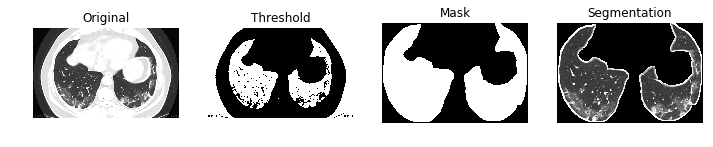

In [15]:
image = gray.get_grayscale_from_dicom("Italy_case010060.dcm", r"D:\Studia\sem7\inzynierka\aplikacja\images_data\pacjent_dcm")
mask = make_lungmask_cropped(image, True)

In [5]:
image = gray.get_grayscale_from_dicom("Italy_case010060.dcm", r"D:\Studia\sem7\inzynierka\aplikacja\images_data\pacjent_dcm")
mask = make_lungmask(image, True)

NameError: name 'make_masklesions' is not defined

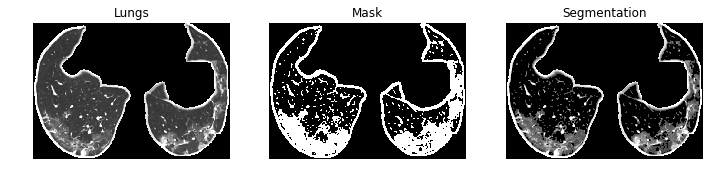

In [43]:
image = gray.get_grayscale_from_dicom("Italy_case010060.dcm", r"D:\Studia\sem7\inzynierka\aplikacja\images_data\pacjent_dcm")
mask = make_lungmask(image, False)

# Dicom Images

In [ ]:
# medical_image = pydicom.dcmread(r"D:\Studia\sem7\inzynierka\aplikacja\images_data\pacjent2_dcm\1-067.dcm")
image = gray.get_grayscale_from_dicom("1-067.dcm", r"D:\Studia\sem7\inzynierka\aplikacja\images_data\pacjent2_dcm")
mask = make_lungmask(image, False)


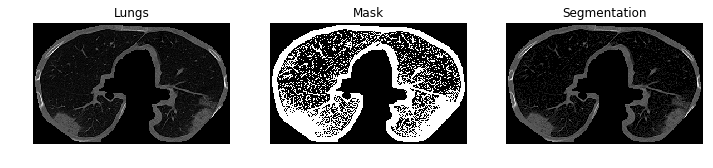

In [44]:
image = gray.get_grayscale_from_dicom("ser203img00109.dcm", r"D:\Studia\sem7\inzynierka\aplikacja\images_data")
# plt.imshow(image, cmap='gray')
mask = make_lungmask(image, False)

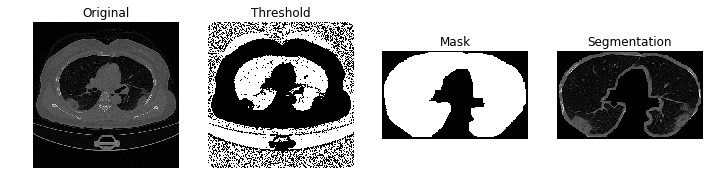

In [12]:
image = gray.get_grayscale_from_dicom("ser203img00109.dcm", r"D:\Studia\sem7\inzynierka\aplikacja\images_data")
mask = make_lungmask_cropped(image, True)

# JPG & PNG Images

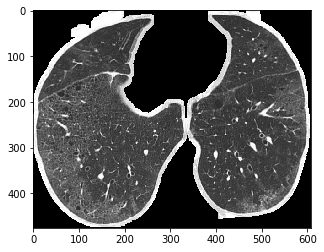

In [55]:
image = gray.get_grayscale_from_jpg_png("covid5.jpg", r"D:\Studia\sem7\inzynierka\aplikacja\images_data")
mask = make_lungmask(image, False)

In [ ]:
image = gray.get_grayscale_from_jpg_png("covid5.png", r"D:\Studia\sem7\inzynierka\aplikacja\images_data")
# mask = make_lungmask(image, True)
# mpimg.imread( r"D:\Studia\sem7\inzynierka\aplikacja\images_data\covid5.png")
# mpimg.imread(str(r"D:\Studia\sem7\inzynierka\aplikacja\images_data\covid5.png"))

# Nifit Images

In [33]:
medical_image = gray.get_plot_data_nii(r"D:\Studia\sem7\inzynierka\aplikacja\images_data\coronacases_org_001.nii", 50)

In [113]:
from scipy import interpolate

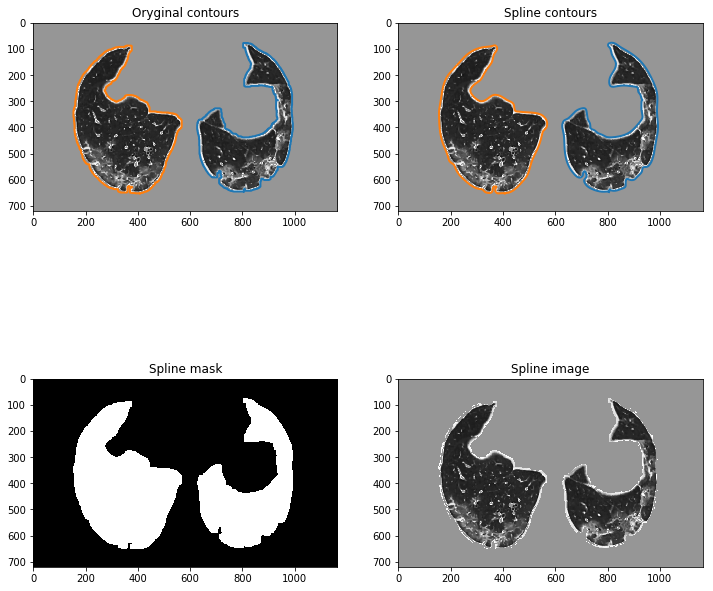

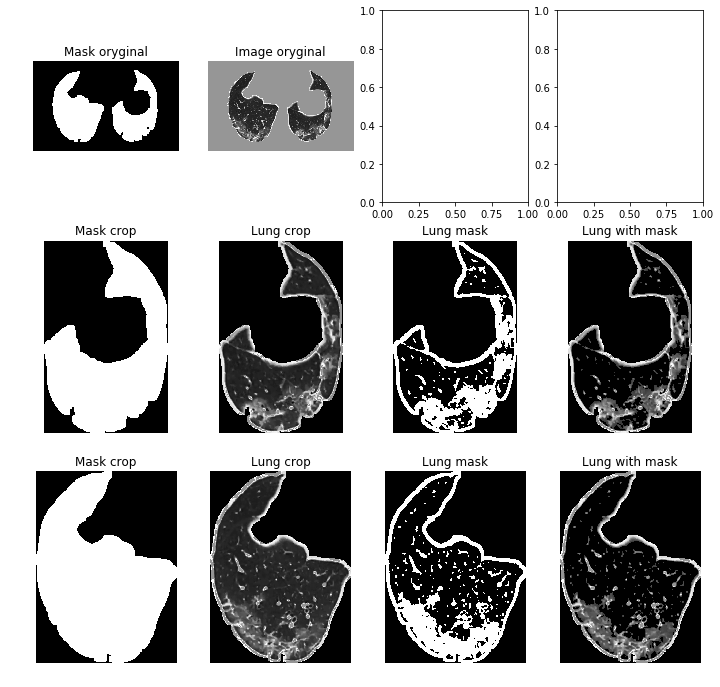

In [7]:
image = gray.get_grayscale_from_dicom("Italy_case010060.dcm", r"D:\Studia\sem7\inzynierka\aplikacja\images_data\pacjent_dcm")
mask = make_lungmask(image, False)